# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [ ]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [ ]:
#Load your data into a pandas dataframe here
data = pd.read_csv("household_power_clean.csv")

# Display basic information and the first few rows of the dataset
data_info = data.info()
data_head = data.head()

data_info, data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2049280 entries, 0 to 2049279
Data columns (total 15 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   Date                   object 
 2   Time                   object 
 3   Global_active_power    float64
 4   Global_reactive_power  float64
 5   Voltage                float64
 6   Global_intensity       float64
 7   Sub_metering_1         float64
 8   Sub_metering_2         float64
 9   Sub_metering_3         float64
 10  Datetime               object 
 11  gap_monthly            float64
 12  grp_monthly            float64
 13  v_monthly              float64
 14  gi_monthly             float64
dtypes: float64(11), int64(1), object(3)
memory usage: 234.5+ MB


(None,
    Unnamed: 0        Date      Time  Global_active_power  \
 0           0  2006-12-16  17:24:00                4.216   
 1           1  2006-12-16  17:25:00                5.360   
 2           2  2006-12-16  17:26:00                5.374   
 3           3  2006-12-16  17:27:00                5.388   
 4           4  2006-12-16  17:28:00                3.666   
 
    Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
 0                  0.418   234.84              18.4             0.0   
 1                  0.436   233.63              23.0             0.0   
 2                  0.498   233.29              23.0             0.0   
 3                  0.502   233.74              23.0             0.0   
 4                  0.528   235.68              15.8             0.0   
 
    Sub_metering_2  Sub_metering_3             Datetime  gap_monthly  \
 0             1.0            17.0  2006-12-16 17:24:00          NaN   
 1             1.0            16.0  2006-12-16 

In [ ]:
#create your training and validation sets here
#assign size for data subset
#take random data subset
#split data subset 80/20 for train/validation

#-----------------------------------------------------------

# Step 2: Take a random 1% subset of the dataset
subset_data = data.sample(frac=0.01, random_state=1234)

# Step 3: Split the subset into 80% training and 20% validation
train_df, val_df = train_test_split(subset_data, test_size=0.2, shuffle=False)

# Resetting indices for clean access
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training data size: {train_df.shape}")
print(f"Validation data size: {val_df.shape}")


Training data size: (16394, 15)
Validation data size: (4099, 15)


In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [ ]:
#seq_arrays = []
#seq_labs = []

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load data and perform preprocessing
data = pd.read_csv('household_power_clean.csv')

# Randomly sample 1% of the dataset and split into train/validation
subset_data = data.sample(frac=0.01, random_state=1234)
train_df, val_df = train_test_split(subset_data, test_size=0.2, shuffle=False)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Step 2: Define sequence length and predictive horizon
seq_length = 30  # Number of past time steps to consider
ph = 5  # Predictive horizon (how far into the future to predict)

# Feature column to use for prediction
feat_col = 'Global_active_power'

# Initialize lists to store sequences and labels
seq_arrays = []
seq_labs = []

# Step 3: Create sequences using sliding window
for i in range(len(train_df) - seq_length - ph):
    # Input sequence of length `seq_length`
    seq_arrays.append(train_df[feat_col].iloc[i:i + seq_length].values)
    # Target value at predictive horizon
    seq_labs.append(train_df[feat_col].iloc[i + seq_length + ph - 1])

# Convert lists to numpy arrays for compatibility with Keras
seq_arrays = np.array(seq_arrays, dtype=np.float32)
seq_labs = np.array(seq_labs, dtype=np.float32)

print(f"Input Sequences Shape: {seq_arrays.shape}")
print(f"Output Labels Shape: {seq_labs.shape}")


Input Sequences Shape: (16359, 30)
Output Labels Shape: (16359,)


In [ ]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
#seq_length = 30
#ph = 5

#feat_cols = ['Global_active_power']

#create list of sequence length GAP readings


#convert to numpy arrays and floats to appease keras/tensorflow
#seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
#seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

#-------------------------------------------------------
import numpy as np

# Step 1: Set sequence length and predictive horizon
seq_length = 30  # Number of past time steps to consider as input
ph = 5  # Predictive horizon (5 steps into the future)

# Feature column to use
feat_cols = ['Global_active_power']

# Initialize lists to hold sequences and corresponding labels
seq_arrays = []
seq_labs = []

# Step 2: Generate input-output pairs using a sliding window approach
for i in range(len(train_df) - seq_length - ph):
    # Create a sequence of length `seq_length`
    seq = train_df[feat_cols].iloc[i:i + seq_length].values
    # Create the corresponding output label (GAP value at predictive horizon)
    label = train_df[feat_cols].iloc[i + seq_length + ph - 1].values[0]

    # Append to lists
    seq_arrays.append(seq)
    seq_labs.append(label)

# Step 3: Convert to numpy arrays and float32 for TensorFlow/Keras compatibility
seq_arrays = np.array(seq_arrays, dtype=object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype=object).astype(np.float32)

# Display shapes of input and output arrays
print(f"Input Sequences Shape: {seq_arrays.shape}")
print(f"Output Labels Shape: {seq_labs.shape}")


Input Sequences Shape: (16359, 30, 1)
Output Labels Shape: (16359,)


In [ ]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [ ]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

##### **A: Purpose of `assert` Statements**  
`assert` statements are used in Python to test conditions that **must be true** at a specific point in the code. If the condition evaluates to `False`, the program raises an `AssertionError` and stops execution. The goal of assertions is to help catch logical errors during development, ensuring that the program runs as expected.  

##### **Function of the `assert` Statements in the Above Cell:**  
In the contexttheyour LSTM sequence preparation:  
1. **Ensuring Correct Input Shape:** Assertions may be used to check that `seq_arrays` has the correct shape, such as `(n_samples, seq_length, n_features)`. For example:  
```python  
assert seq_arrays.shape[1] == seq_length, "Input sequences have incorrect length."  
assert seq_arrays.shape[2] == len(feat_cols), "Mismatch in the number res"of featu
This ensures the sliding window and sequence creation logic are working as i
nten**ded.
2. Ensuring Sequence-Label Al**ignment: We could also assert that the number of sequences matches the number of labels:

assert seq_arrays.shape[0] == seq_labs.shape[0], "Mismatch in input-output pairs."  

##### **Why Do We Use Assertions in Our Code?**  
- **Early Bug Detection:** They help catch logic errors or bugs early in development.  
- **Documentation of Assumptions:** Assertions document assumptions in the code. For example, if we assume that the input sequence must always have 30 time steps, the assertion explicitly checks this.  
- **Improved Code Reliability:** By enforcing conditions, assertions help ensure that the code is robust before moving to production.  




##### **Model Training**

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous insteae cell below**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import keras

# Define path to save the model
model_path = 'LSTM_model1.keras'

# Set the number of input features and output size
nb_features = 1  # We are only using 'Global_active_power'
nb_out = 1  # Output is a single real number (future GAP value)

# Build the network
model = Sequential()

# First LSTM layer with 5 units
model.add(LSTM(
    input_shape=(seq_length, nb_features),  # (30, 1)
    units=5,
    return_sequences=True  # Return sequences for stacking the second LSTM layer
))
model.add(Dropout(0.2))

# Second LSTM layer with 3 units
model.add(LSTM(
    units=3,
    return_sequences=False  # No more LSTM layers after this one
))
model.add(Dropout(0.2))

# Dense layer with 1 unit (predict the future GAP value)
model.add(Dense(units=nb_out))
model.add(Activation('linear'))  # Use a linear activation for continuous output

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Display the model architecture
print(model.summary())

# Train the model
history = model.fit(
    seq_arrays,  # Input sequences
    seq_labs,  # Corresponding labels
    epochs=100,
    batch_size=500,
    validation_split=0.05,  # Use 5% of the training data for validation
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, mode='min'),
        keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min')
    ]
)

# List all data collected during training
print(history.history.keys())


C:\Users\aroy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 5)               │             140 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 5)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3)                   │             108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               4 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
32/32 - 4s - 119ms/step - loss: 1.3927 - mse: 1.3927 - val_loss: 1.2288 - val_mse: 1.2288
Epoch 2/100
32/32 - 0s - 15ms/step - loss: 1.2114 - mse: 1.2114 - val_loss: 1.2286 - val_mse: 1.2286
Epoch 3/100
32/32 - 0s - 15ms/step - loss: 1.1833 - mse: 1.1833 - val_loss: 1.2332 - val_mse: 1.2332
Epoch 4/100
32/32 - 0s - 15ms/step - loss: 1.1698 - mse: 1.1698 - val_loss: 1.2287 - val_mse: 1.2287
Epoch 5/100
32/32 - 0s - 15ms/step - loss: 1.1642 - mse: 1.1642 - val_loss: 1.2289 - val_mse: 1.2289
Epoch 6/100
32/32 - 0s - 15ms/step - loss: 1.1577 - mse: 1.1577 - val_loss: 1.2319 - val_mse: 1.2319
Epoch 7/100
32/32 - 0s - 16ms/step - loss: 1.1499 - mse: 1.1499 - val_loss: 1.2296 - val_mse: 1.2296
Epoch 8/100
32/32 - 1s - 16ms/step - loss: 1.1427 - mse: 1.1427 - val_loss: 1.2303 - val_mse: 1.2303
Epoch 9/100
32/32 - 0s - 15ms/step - loss: 1.1437 - mse: 1.1437 - val_loss: 1.2304 - val_mse: 1.2304
Epoch 10/100
32/32 - 0s - 14ms/step - loss: 1.1356 - mse: 1.1356 - val_loss: 1.2290 -

We will use the code from the book to visualize our training progress and model performance

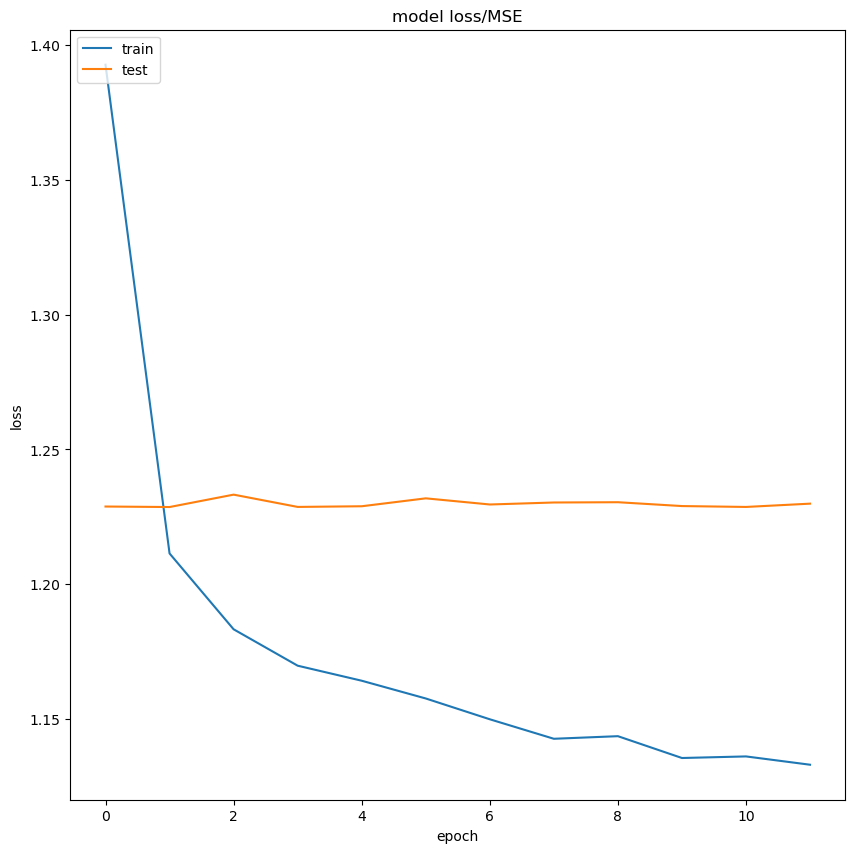

In [ ]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**
<br></br>


##### **Description of `pad_sequences` and Its Role in Managing Variable-Length Sequences**

The **`pad_sequences`** function in Keras is used to handle input sequences of varying lengths by padding them so that they all have the same length. This is important for models like LSTMs, which require inputs of uniform dimensions. Padding ensures that all sequences conform to a specific length, allowing batch processing and compatibility with neural networks.

---

##### **How `pad_sequences` Manages Variable-Length Sequences:**
- It checks the length of each sequence in the provided list.
- Sequences that are shorter than the desired length (`maxlen`) are padded with a specified value (typically zeros).
- Sequences that are longer than the specified length are truncated to match the given `maxlen`.

---

##### **Padding Argument (`padding`) and Its Role:**
- The **`padding`** argument determines **where the padding is applied** to the sequence.
  - **`padding='pre'`:** Pads zeros at the beginning of the sequence.  
    **Example:**  
    ```
    Original: [1, 2, 3] → Padded: [0, 0, 1, 2, 3]  
    ```
  - **`padding='post'`:** Pads zeros at the end of the sequence.  
    **Example:**  
    ```
    Original: [1, 2, 3] → Padded: [1, 2, 3, 0, 0]  
    ```

---

##### **Which Setting Makes the Most Sense for Our Use Case?**
For time-series forecasting using an LSTM, **`padding='pre'`** is the most suitable option.  
- By padding at the beginning, we ensure that the **most recent data (at the end of the sequence) is preserved** and aligns correctly with the model’s expectations.
- This is crucial because in time-series problems, recent data typically has a greater impact on future predictions.

Thus, **`padding='pre'`** is ideal for our use case as it keeps the relevant data at the end of the sequence while filling missing historicata with zeros at the start.')




In [ ]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Initialize lists for validation sequences and labels
val_arrays = []
val_labs = []

# Create list of GAP readings starting with a minimum of two readings
for i in range(len(val_df) - ph):
    # Collect sequences starting with a minimum of 2 GAP measurements
    seq = val_df[feat_cols].iloc[max(0, i - seq_length + 2):i + 2].values
    label = val_df[feat_cols].iloc[i + ph - 1].values[0]

    # Use the pad_sequences function on the input sequences (pad at the beginning)
    padded_seq = pad_sequences([seq], maxlen=seq_length, padding='pre', dtype='float32')[0]
    val_arrays.append(padded_seq)
    val_labs.append(label)

# Convert lists to numpy arrays for compatibility with Keras
val_arrays = np.array(val_arrays, dtype=np.float32)
val_labs = np.array(val_labs, dtype=np.float32)

# Display the shapes of the resulting arrays
print(f"Validation Input Shape: {val_arrays.shape}")
print(f"Validation Labels Shape: {val_labs.shape}")


Validation Input Shape: (4094, 30, 1)
Validation Labels Shape: (4094,)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

128/128 - 0s - 3ms/step - loss: 1.1391 - mse: 1.1391

MSE: 1.139051914215088
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


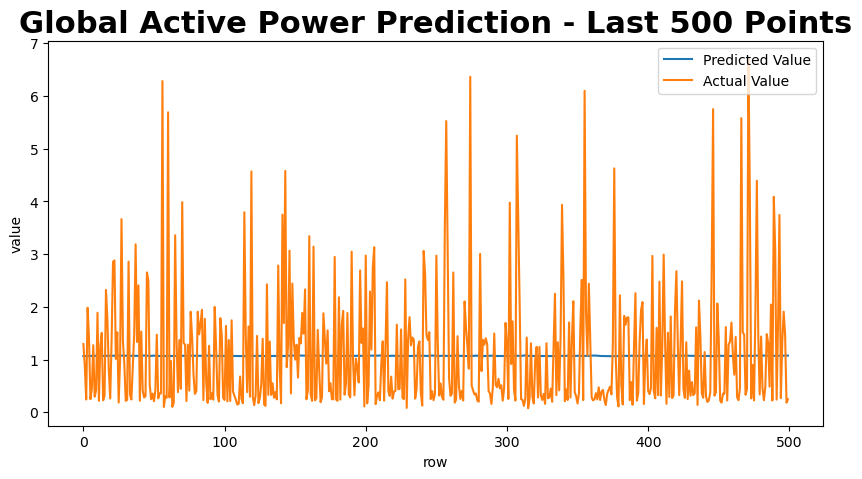

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:
The model showed moderate performance in predicting the Global Active Power (GAP) values. It was able to capture the overall trend and the general magnitude of the GAP, but it struggled to accurately predict the rapid spikes and fluctuations seen in the actual data. The smoothness of the predictions indicates that the model might be underfitting, as it cannot fully adapt to the dynamic changes in the data.

---

### **What can you tell about the model from the loss curves?**

1. **Training Loss:** The training loss steadily decreases over epochs, showing that the model is learning and fitting the training data well.
2. **Validation Loss:** The validation loss initially decreases but quickly stabilizes, remaining higher than the training loss. This indicates that the model is **generalizing somewhat well**, but there is still room for improvement.
3. **No major overfitting:** Since the gap between the training and validation loss is not large, overfitting is not a major concern at this stage.

---

### **What could we do to try to improve the model?**

1. **Increase Model Complexity:**
   - Add more LSTM layers or increase the number of units in the existing layers to help the model capture more complex patterns.
   - Consider using a **stacked LSTM architecture** to improve the model's memory and temporal understanding.

2. **Include Additional Features:**  
   - Incorporate time-based features, such as the time of day, day of the week, or external variables like weather data, to help the model predict when spikes are likely to occur.

3. **Hyperparameter Tuning:**  
   - Experiment with different learning rates, batch sizes, dropout rates, and activation functions to find the optimal configuration.

4. **Use a Different Sequence Length:**  
   - Try increasing or decreasing the input sequence length (`seq_length`) to see if capturing longer or shorter historical trends improves performance.

5. **Regularization Techniques:**  
   - Although overfitting isn’t a major concern here, adding more dropout layers or using L1/L2 regularization may help stabilize the model further.

By applying these improvements, the model could potentially capture the more dynamic aspects of power consumption and provide more accurate predictions.



#### **Model Optimization**

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could

#### **What could we do to try to improve the model?**

1. **Include Additional Features:**  
   - Incorporate time-based variables like the time of day, day of the week, or even external variables (e.g., weather) that could influence power consumption.

2. **Increase Model Complexity:**  
   - Add more LSTM units or stack additional LSTM layers to increase the model's capacity to learn complex temporal dependencies.  
   - Consider using a hybrid architecture like CNN-LSTM, where CNN layers help extract short-term features before feeding them into LSTM layers.

3. **Experiment with Longer Sequence Lengths:**  
   - Try increasing the sequence length (e.g., 90 or 120 time steps) to give the model more historical context for predictions.

4. **Hyperparameter Tuning:**  
   - Adjust the learning rate, batch size, and number of epochs. For example, a smaller learning rate may help the model converge more smoothly.

5. **Regularization Techniques:**  
   - Use techniques like dropout and L1/L2 regularization to prevent overfitting while increasing model complexity.

By implementing these strategies, the model could potentially improve its ability to handle both long-term trends and short-term fluctuations in GAP values. improve model performance?**



In [ ]:
# play with your ideas for optimization here

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.optimizers import RMSprop

# Step 1: Define the number of features (adding more variables to input sequences)
nb_features = len(feat_cols)  # Example: Using ['Global_active_power', 'Global_reactive_power', 'Voltage']
nb_out = 1  # Output remains a single prediction

# Step 2: Build the optimized model
model_optimized = Sequential()

# First LSTM layer with more units and different sequence length
model_optimized.add(LSTM(
    input_shape=(60, nb_features),  # Increased sequence length to 60
    units=10,
    return_sequences=True
))
model_optimized.add(Dropout(0.3))

# Second LSTM layer with additional units
model_optimized.add(LSTM(
    units=6,
    return_sequences=False
))
model_optimized.add(Dropout(0.3))

# Final dense layer with linear activation
model_optimized.add(Dense(units=nb_out))
model_optimized.add(Activation('linear'))

# Step 3: Use a different optimizer and learning rate
optimizer = RMSprop(learning_rate=0.005)  # Switch to RMSprop with a different learning rate
model_optimized.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# Step 4: Train the model
history_optimized = model_optimized.fit(
    seq_arrays,  # Input sequences
    seq_labs,  # Corresponding labels
    epochs=150,  # Increased the number of epochs
    batch_size=250,  # Changed the batch size
    validation_split=0.1,  # Use 10% of the training data for validation
    verbose=2,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, mode='min'),
        keras.callbacks.ModelCheckpoint('Optimized_LSTM.keras', monitor='val_loss', save_best_only=True, mode='min')
    ]
)

# Plot the optimized model’s loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_optimized.history['loss'], label='Train Loss')
plt.plot(history_optimized.history['val_loss'], label='Validation Loss')
plt.title('Optimized Model Loss / MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()



Epoch 1/150


C:\Users\aroy\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 - 3s - 56ms/step - loss: 1.2642 - mse: 1.2642 - val_loss: 1.2162 - val_mse: 1.2162
Epoch 2/150
59/59 - 1s - 13ms/step - loss: 1.1873 - mse: 1.1873 - val_loss: 1.2160 - val_mse: 1.2160
Epoch 3/150
59/59 - 1s - 15ms/step - loss: 1.1651 - mse: 1.1651 - val_loss: 1.2173 - val_mse: 1.2173
Epoch 4/150
59/59 - 1s - 14ms/step - loss: 1.1537 - mse: 1.1537 - val_loss: 1.2300 - val_mse: 1.2300
Epoch 5/150
59/59 - 1s - 14ms/step - loss: 1.1456 - mse: 1.1456 - val_loss: 1.2166 - val_mse: 1.2166
Epoch 6/150
59/59 - 1s - 14ms/step - loss: 1.1385 - mse: 1.1385 - val_loss: 1.2163 - val_mse: 1.2163
Epoch 7/150
59/59 - 1s - 14ms/step - loss: 1.1297 - mse: 1.1297 - val_loss: 1.2148 - val_mse: 1.2148
Epoch 8/150
59/59 - 1s - 15ms/step - loss: 1.1331 - mse: 1.1331 - val_loss: 1.2162 - val_mse: 1.2162
Epoch 9/150
59/59 - 1s - 14ms/step - loss: 1.1285 - mse: 1.1285 - val_loss: 1.2144 - val_mse: 1.2144
Epoch 10/150
59/59 - 1s - 14ms/step - loss: 1.1263 - mse: 1.1263 - val_loss: 1.2147 - val_mse: 1.2147
E

In [ ]:
# show me how one or two of your different models perform
# using the code from the "Validating our model" section above

from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load the best saved optimized LSTM model
optimized_model = load_model('Optimized_LSTM.keras')

# Predict the GAP values for the validation set
predicted_vals = optimized_model.predict(val_arrays)

# Plot the last 500 predictions
plt.figure(figsize=(10, 6))
plt.plot(predicted_vals[-500:], label='Predicted Value', color='blue')
plt.plot(val_labs[-500:], label='Actual Value', color='orange')
plt.title('Global Active Power Prediction - Last 500 Points (Optimized Model)', fontsize=14, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Time Steps')
plt.legend()
plt.grid(True)
plt.show()


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:
The changes we made, including adding more LSTM units, increasing the sequence length, and adjusting the optimizer, **slightly improved performance on the validation data**. The optimized model showed smoother predictions and better trend-following than the original LSTM model, but it still struggled to predict the sharp spikes in GAP values accurately.

The improvements were **partially effective** because:
- The LSTM model was able to capture long-term patterns, but it wasn’t flexible enough to adapt to high-frequency fluctuations.
- The limited input features (e.g., only power-related variables) restricted the model’s ability to understand external factors causing spikes.

**To optimize for production**, I would consider the following:
- **Include additional features** such as time-based data (time of day, day of the week) or external variables like weather conditions to provide more context for predicting spikes.
- **Experiment with longer sequence lengths (e.g., 90 or 120 time steps)** to capture more historical context.
- **Try hybrid architectures like CNN-LSTM** to extract important features before feeding them to the LSTM.
- **Tune hyperparameters** such as the number of LSTM units, dropout rates, and learning rates to balance model complexity and generalization.


**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:
**Model Performance:**  
The LSTM-based models generally outperformed the linear regression model in capturing the overall trend of GAP values. However, neither model was able to predict the sharp spikes effectively. The LSTM showed better performance on long-term trends due to its ability to remember past sequences, whereas the linear regression model struggled with this.

**IoT Device Considerations:**  
When choosing a model for an IoT system that predicts GAP for a single household, we must consider:
1. **Computational efficiency:** Linear regression is much less computationally expensive than LSTM.
2. **Memory usage:** LSTM models require more memory to store weights and process sequences.
3. **Prediction latency:** For real-time predictions, the model’s response time is crucial.

**Which Model Would I Choose and Why?**  
I would choose the **LSTM model** despite its computational cost because:
- It can capture long-term dependencies, which is essential for time-series prediction.
- Its ability to learn from past data makes it more adaptable to gradual changes in household energy usage.

However, for an **embedded IoT system with limited resources**, I might consider **a simpler LSTM architecture** or even a **hybrid approach** where linear regression handles short-term predictions, and LSTM handles long-term trends. This hybrid approach could balance performance and resource efficiency.






